<a href="https://colab.research.google.com/github/kridtapon/RSI-Optimization/blob/main/RSI_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


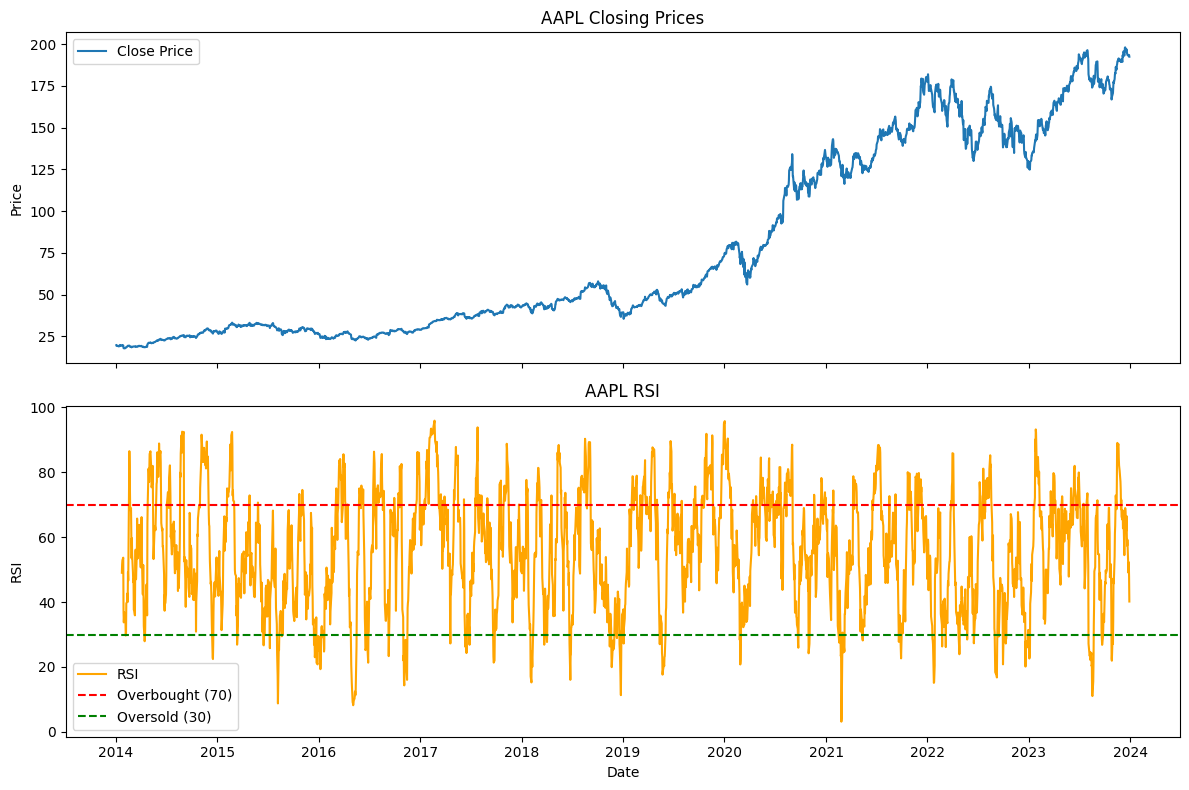

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

def calculate_rsi(data, period=14):
    """
    Calculate the Relative Strength Index (RSI).
    :param data: DataFrame with 'Close' column containing closing prices.
    :param period: Period for calculating RSI, default is 14.
    :return: DataFrame with RSI values.
    """
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    data['RSI'] = rsi

    return data

def plot_rsi(data, ticker):
    """
    Plot closing prices and RSI.
    :param data: DataFrame with 'Close' and 'RSI' columns.
    :param ticker: Stock ticker symbol for the title.
    """
    fig, axes = plt.subplots(2, figsize=(12, 8), sharex=True)

    # Plot closing price
    axes[0].plot(data.index, data['Close'], label='Close Price')
    axes[0].set_title(f'{ticker} Closing Prices')
    axes[0].set_ylabel('Price')
    axes[0].legend()

    # Plot RSI
    axes[1].plot(data.index, data['RSI'], label='RSI', color='orange')
    axes[1].axhline(70, color='red', linestyle='--', label='Overbought (70)')
    axes[1].axhline(30, color='green', linestyle='--', label='Oversold (30)')
    axes[1].set_title(f'{ticker} RSI')
    axes[1].set_ylabel('RSI')
    axes[1].set_xlabel('Date')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Fetch stock data
ticker = "AAPL"  # Replace with your preferred stock ticker
data = yf.download(ticker, start="2014-01-01", end="2024-01-01")

# Calculate RSI
data = calculate_rsi(data)

# Plot RSI
plot_rsi(data, ticker)


In [ ]:
# Fetch stock data
ticker = "AAPL"  # Replace with your preferred stock ticker
data = yf.download(ticker, start="2014-01-01", end="2024-01-01")

[*********************100%***********************]  1 of 1 completed


In [ ]:
data_clean = data.copy()
data_clean = data_clean.ffill()
data_clean.columns = ['Adj Close','Close','High','Low','Open','Volume']
data_clean
df_N = data_clean.copy()
df_N

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2014-01-02,17.234297,19.754642,19.893929,19.715000,19.845715,234684800
2014-01-03,16.855734,19.320715,19.775000,19.301071,19.745001,392467600
2014-01-06,16.947643,19.426071,19.528570,19.057142,19.194643,412610800
2014-01-07,16.826447,19.287144,19.498571,19.211430,19.440001,317209200
2014-01-08,16.933004,19.409286,19.484285,19.238930,19.243214,258529600
...,...,...,...,...,...,...
2023-12-22,192.656189,193.600006,195.410004,192.970001,195.179993,37122800
2023-12-26,192.108856,193.050003,193.889999,192.830002,193.610001,28919300
2023-12-27,192.208359,193.149994,193.500000,191.089996,192.490005,48087700


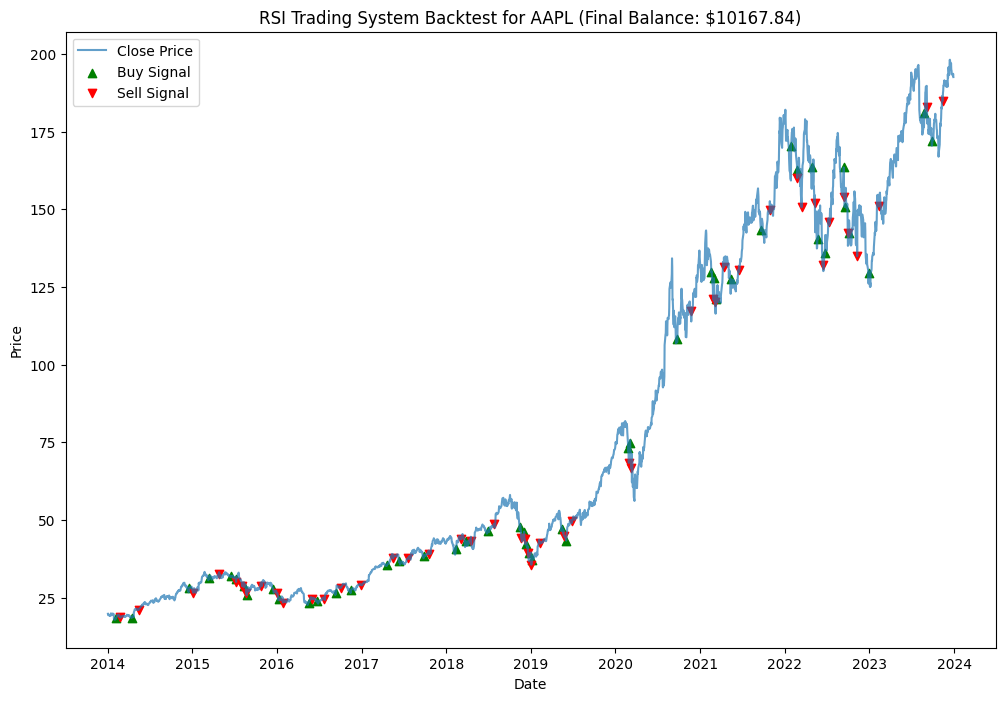

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

def calculate_rsi(data, period=14):
    """
    Calculate the Relative Strength Index (RSI).
    :param data: DataFrame with 'Close' column containing closing prices.
    :param period: Period for calculating RSI, default is 14.
    :return: DataFrame with RSI values.
    """
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    data['RSI'] = rsi
    return data

def backtest_rsi(data, rsi_period=14, initial_balance=10000, stop_loss_pct=0.05):
    """
    Backtest an RSI trading strategy.
    :param data: DataFrame with stock price data and RSI.
    :param rsi_period: RSI period for calculation.
    :param initial_balance: Starting account balance.
    :param stop_loss_pct: Stop-loss percentage.
    :return: DataFrame with trades and performance metrics.
    """
    # Prepare the data
    data = calculate_rsi(data, period=rsi_period)
    balance = initial_balance
    position = 0
    trade_log = []

    for i in range(1, len(data)):
        row = data.iloc[i]
        prev_row = data.iloc[i - 1]

        # Buy signal: RSI crosses above 30
        if position == 0 and prev_row['RSI'] < 30 and row['RSI'] >= 30:
            position = balance / row['Close']  # Buy all in
            entry_price = row['Close']
            balance = 0  # Deduct balance since it's all invested
            trade_log.append({"Type": "Buy", "Date": row.name, "Price": row['Close'], "Balance": 0})

        # Sell signal: RSI crosses below 70 or stop-loss triggered
        elif position > 0:
            stop_loss_price = entry_price * (1 - stop_loss_pct)
            if (row['RSI'] <= 70 and prev_row['RSI'] > 70) or row['Close'] <= stop_loss_price:
                balance = position * row['Close']  # Sell all
                position = 0
                trade_log.append({"Type": "Sell", "Date": row.name, "Price": row['Close'], "Balance": balance})

    # Final balance if holding a position
    if position > 0:
        balance += position * data.iloc[-1]['Close']

    # Convert trade log to DataFrame
    trades = pd.DataFrame(trade_log)
    return trades, balance

def plot_backtest(data, trades, balance, ticker):
    """
    Plot the backtest results.
    :param data: DataFrame with stock price data.
    :param trades: DataFrame with trade log.
    :param balance: Final balance after backtesting.
    :param ticker: Stock ticker symbol.
    """
    plt.figure(figsize=(12, 8))

    # Plot closing price
    plt.plot(data.index, data['Close'], label='Close Price', alpha=0.7)
    plt.scatter(trades[trades['Type'] == 'Buy']['Date'], trades[trades['Type'] == 'Buy']['Price'],
                marker='^', color='green', label='Buy Signal', alpha=1)
    plt.scatter(trades[trades['Type'] == 'Sell']['Date'], trades[trades['Type'] == 'Sell']['Price'],
                marker='v', color='red', label='Sell Signal', alpha=1)

    plt.title(f'RSI Trading System Backtest for {ticker} (Final Balance: ${balance:.2f})')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Fetch stock data
ticker = "AAPL"  # Replace with your preferred stock ticker
data = df_N

# Backtest RSI strategy
trades, final_balance = backtest_rsi(data)

# Plot the results
plot_backtest(data, trades, final_balance, ticker)

Best Parameters:
RSI Period             12.000000
Overbought Level       85.000000
Oversold Level         35.000000
Stop Loss %             0.100000
Final Balance       59341.055541
Name: 599, dtype: float64


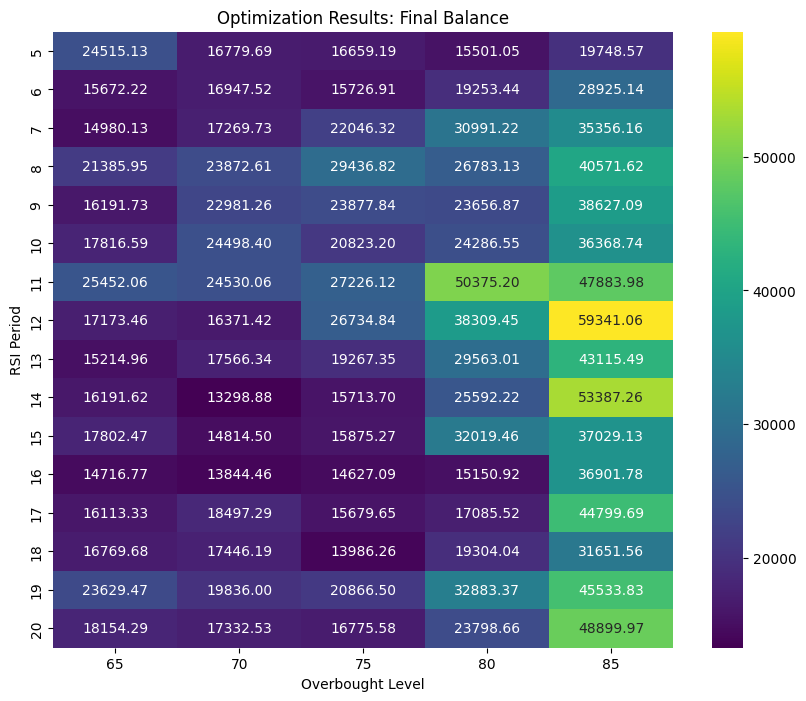

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from itertools import product
import seaborn as sns

def calculate_rsi(data, period=14):
    """
    Calculate the Relative Strength Index (RSI).
    """
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    data['RSI'] = rsi
    return data

def backtest_rsi(data, rsi_period=14, overbought=70, oversold=30, stop_loss_pct=0.05, initial_balance=10000):
    """
    Backtest an RSI trading strategy.
    """
    data = calculate_rsi(data, period=rsi_period)
    balance = initial_balance
    position = 0
    entry_price = 0

    for i in range(1, len(data)):
        row = data.iloc[i]
        prev_row = data.iloc[i - 1]

        # Buy signal: RSI crosses above the oversold level
        if position == 0 and prev_row['RSI'] < oversold and row['RSI'] >= oversold:
            position = balance / row['Close']
            entry_price = row['Close']
            balance = 0

        # Sell signal: RSI crosses below the overbought level or stop-loss triggered
        elif position > 0:
            stop_loss_price = entry_price * (1 - stop_loss_pct)
            if (row['RSI'] <= overbought and prev_row['RSI'] > overbought) or row['Close'] <= stop_loss_price:
                balance = position * row['Close']
                position = 0

    # Final balance if holding a position
    if position > 0:
        balance += position * data.iloc[-1]['Close']

    return balance

def optimize_rsi(data, rsi_periods, overbought_levels, oversold_levels, stop_loss_pcts):
    """
    Optimize RSI parameters.
    """
    results = []

    # Iterate over all parameter combinations
    for rsi_period, overbought, oversold, stop_loss_pct in product(rsi_periods, overbought_levels, oversold_levels, stop_loss_pcts):
        if overbought <= oversold:
            continue  # Skip invalid combinations

        final_balance = backtest_rsi(data, rsi_period, overbought, oversold, stop_loss_pct)
        results.append({
            'RSI Period': rsi_period,
            'Overbought Level': overbought,
            'Oversold Level': oversold,
            'Stop Loss %': stop_loss_pct,
            'Final Balance': final_balance
        })

    results_df = pd.DataFrame(results)
    return results_df

def plot_optimization_results(results_df):
    """
    Plot the optimization results.
    """
    pivot = results_df.pivot_table(
        index='RSI Period',
        columns='Overbought Level',
        values='Final Balance',
        aggfunc='max'
    )

    plt.figure(figsize=(10, 8))
    plt.title("Optimization Results: Final Balance")
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="viridis")
    plt.xlabel("Overbought Level")
    plt.ylabel("RSI Period")
    plt.show()

# Fetch stock data
ticker = "AAPL"  # Replace with your preferred stock ticker
data = df_N

# Optimize RSI parameters
rsi_periods = range(5, 21, 1)  # RSI periods from 5 to 20
overbought_levels = range(65, 86, 5)  # Overbought levels from 65 to 85
oversold_levels = range(15, 36, 5)  # Oversold levels from 15 to 35
stop_loss_pcts = [0.02, 0.05, 0.1]  # Stop-loss percentages

results_df = optimize_rsi(data, rsi_periods, overbought_levels, oversold_levels, stop_loss_pcts)

# Find the best parameters
best_params = results_df.loc[results_df['Final Balance'].idxmax()]
print("Best Parameters:")
print(best_params)

# Plot optimization results
plot_optimization_results(results_df)


Best Parameters:
RSI Period             12.000000
Overbought Level       85.000000
Oversold Level         35.000000
Stop Loss %             0.100000
Final Balance       59341.055541
Max Drawdown           -0.381430
Name: 599, dtype: float64


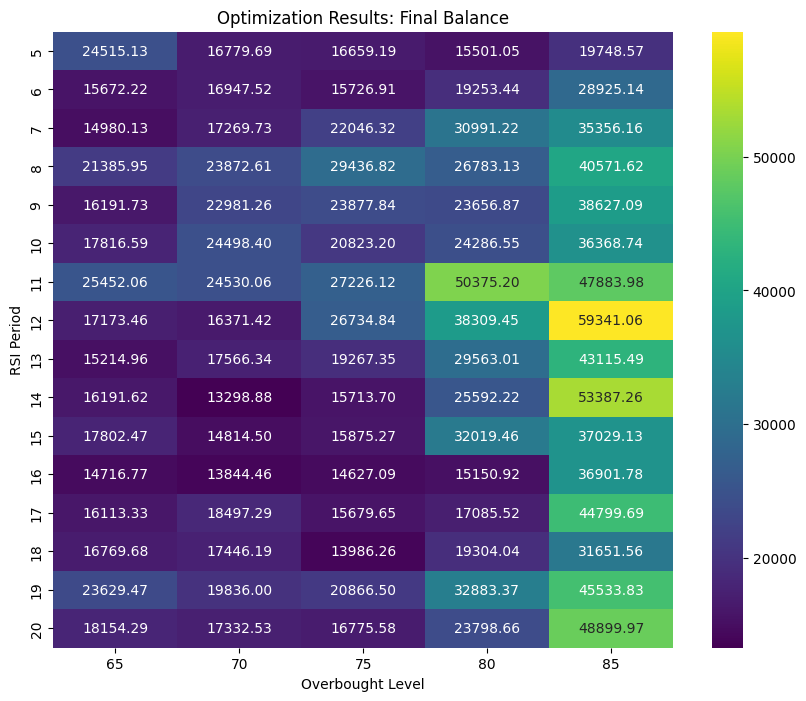

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from itertools import product
import seaborn as sns

def calculate_rsi(data, period=14):
    """
    Calculate the Relative Strength Index (RSI).
    """
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    data['RSI'] = rsi
    return data

def calculate_drawdown(equity_curve):
    """
    Calculate drawdown and maximum drawdown from an equity curve.
    """
    rolling_max = equity_curve.cummax()
    drawdown = (equity_curve - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    return drawdown, max_drawdown

def backtest_rsi(data, rsi_period=14, overbought=70, oversold=30, stop_loss_pct=0.05, initial_balance=10000):
    """
    Backtest an RSI trading strategy.
    """
    data = calculate_rsi(data, period=rsi_period)
    balance = initial_balance
    position = 0
    entry_price = 0
    equity_curve = [initial_balance]  # Track balance over time

    for i in range(1, len(data)):
        row = data.iloc[i]
        prev_row = data.iloc[i - 1]

        # Buy signal: RSI crosses above the oversold level
        if position == 0 and prev_row['RSI'] < oversold and row['RSI'] >= oversold:
            position = balance / row['Close']
            entry_price = row['Close']
            balance = 0

        # Sell signal: RSI crosses below the overbought level or stop-loss triggered
        elif position > 0:
            stop_loss_price = entry_price * (1 - stop_loss_pct)
            if (row['RSI'] <= overbought and prev_row['RSI'] > overbought) or row['Close'] <= stop_loss_price:
                balance = position * row['Close']
                position = 0

        # Update equity curve
        equity_curve.append(balance if position == 0 else position * row['Close'])

    # Final balance if holding a position
    if position > 0:
        balance += position * data.iloc[-1]['Close']
        equity_curve.append(balance)

    # Calculate drawdown
    equity_curve = pd.Series(equity_curve)
    drawdown, max_drawdown = calculate_drawdown(equity_curve)

    return balance, max_drawdown, equity_curve

def optimize_rsi(data, rsi_periods, overbought_levels, oversold_levels, stop_loss_pcts):
    """
    Optimize RSI parameters.
    """
    results = []

    # Iterate over all parameter combinations
    for rsi_period, overbought, oversold, stop_loss_pct in product(rsi_periods, overbought_levels, oversold_levels, stop_loss_pcts):
        if overbought <= oversold:
            continue  # Skip invalid combinations

        final_balance, max_drawdown, _ = backtest_rsi(data, rsi_period, overbought, oversold, stop_loss_pct)
        results.append({
            'RSI Period': rsi_period,
            'Overbought Level': overbought,
            'Oversold Level': oversold,
            'Stop Loss %': stop_loss_pct,
            'Final Balance': final_balance,
            'Max Drawdown': max_drawdown
        })

    results_df = pd.DataFrame(results)
    return results_df

def plot_optimization_results(results_df):
    """
    Plot the optimization results.
    """
    pivot = results_df.pivot_table(
        index='RSI Period',
        columns='Overbought Level',
        values='Final Balance',
        aggfunc='max'
    )

    plt.figure(figsize=(10, 8))
    plt.title("Optimization Results: Final Balance")
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="viridis")
    plt.xlabel("Overbought Level")
    plt.ylabel("RSI Period")
    plt.show()

# Fetch stock data
ticker = "AAPL"  # Replace with your preferred stock ticker
data = df_N

# Optimize RSI parameters
rsi_periods = range(5, 21, 1)  # RSI periods from 5 to 20
overbought_levels = range(65, 86, 5)  # Overbought levels from 65 to 85
oversold_levels = range(15, 36, 5)  # Oversold levels from 15 to 35
stop_loss_pcts = [0.02, 0.05, 0.1]  # Stop-loss percentages

results_df = optimize_rsi(data, rsi_periods, overbought_levels, oversold_levels, stop_loss_pcts)

# Find the best parameters
best_params = results_df.loc[results_df['Final Balance'].idxmax()]
print("Best Parameters:")
print(best_params)

# Plot optimization results
plot_optimization_results(results_df)

In [ ]:
df_N

,Adj Close,Close,High,Low,Open,Volume,RSI
Date,,,,,,,
2014-01-02,17.234297,19.754642,19.893929,19.715000,19.845715,234684800,NaN
2014-01-03,16.855734,19.320715,19.775000,19.301071,19.745001,392467600,NaN
2014-01-06,16.947643,19.426071,19.528570,19.057142,19.194643,412610800,NaN
2014-01-07,16.826447,19.287144,19.498571,19.211430,19.440001,317209200,NaN
2014-01-08,16.933004,19.409286,19.484285,19.238930,19.243214,258529600,NaN
...,...,...,...,...,...,...,...
2023-12-22,192.656189,193.600006,195.410004,192.970001,195.179993,37122800,56.470586
2023-12-26,192.108856,193.050003,193.889999,192.830002,193.610001,28919300,55.735406
2023-12-27,192.208359,193.149994,193.500000,191.089996,192.490005,48087700,54.926544


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from itertools import product
import seaborn as sns

def calculate_rsi(data, period=14):
    """
    Calculate the Relative Strength Index (RSI).
    """
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    data['RSI'] = rsi
    return data

def calculate_drawdown(equity_curve):
    """
    Calculate drawdown and maximum drawdown from an equity curve.
    """
    rolling_max = equity_curve.cummax()
    drawdown = (equity_curve - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    return drawdown, max_drawdown

def backtest_rsi(data, rsi_period=14, overbought=70, oversold=30, stop_loss_pct=0.05, initial_balance=10000):
    """
    Backtest an RSI trading strategy.
    """
    data = calculate_rsi(data, period=rsi_period)
    balance = initial_balance
    position = 0
    entry_price = 0
    equity_curve = [initial_balance]  # Track balance over time

    for i in range(1, len(data)):
        row = data.iloc[i]
        prev_row = data.iloc[i - 1]

        # Buy signal: RSI crosses above the oversold level
        if position == 0 and prev_row['RSI'] < oversold and row['RSI'] >= oversold:
            position = balance / row['Close']
            entry_price = row['Close']
            balance = 0

        # Sell signal: RSI crosses below the overbought level or stop-loss triggered
        elif position > 0:
            stop_loss_price = entry_price * (1 - stop_loss_pct)
            if (row['RSI'] <= overbought and prev_row['RSI'] > overbought) or row['Close'] <= stop_loss_price:
                balance = position * row['Close']
                position = 0

        # Update equity curve
        equity_curve.append(balance if position == 0 else position * row['Close'])

    # Final balance if holding a position
    if position > 0:
        balance += position * data.iloc[-1]['Close']
        equity_curve.append(balance)

    # Calculate drawdown
    equity_curve = pd.Series(equity_curve)
    drawdown, max_drawdown = calculate_drawdown(equity_curve)

    return balance, max_drawdown, equity_curve

def optimize_rsi(data, rsi_periods, overbought_levels, oversold_levels, stop_loss_pcts):
    """
    Optimize RSI parameters.
    """
    results = []

    # Iterate over all parameter combinations
    for rsi_period, overbought, oversold, stop_loss_pct in product(rsi_periods, overbought_levels, oversold_levels, stop_loss_pcts):
        if overbought <= oversold:
            continue  # Skip invalid combinations

        final_balance, max_drawdown, _ = backtest_rsi(data, rsi_period, overbought, oversold, stop_loss_pct)
        results.append({
            'RSI Period': rsi_period,
            'Overbought Level': overbought,
            'Oversold Level': oversold,
            'Stop Loss %': stop_loss_pct,
            'Final Balance': final_balance,
            'Max Drawdown': max_drawdown
        })

    results_df = pd.DataFrame(results)
    return results_df

def plot_optimization_results(results_df):
    """
    Plot the optimization results.
    """
    pivot = results_df.pivot_table(
        index='RSI Period',
        columns='Overbought Level',
        values='Final Balance',
        aggfunc='max'
    )

    plt.figure(figsize=(10, 8))
    plt.title("Optimization Results: Final Balance")
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="viridis")
    plt.xlabel("Overbought Level")
    plt.ylabel("RSI Period")
    plt.show()

def plot_equity_curve(equity_curve):
    """
    Plot the equity curve.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(equity_curve, label='Equity Curve', color='blue')
    plt.title("Equity Curve")
    plt.xlabel("Time")
    plt.ylabel("Equity Value")
    plt.legend()
    plt.grid()
    plt.show()

# Fetch stock data
ticker = "AAPL"  # Replace with your preferred stock ticker
data = df_N

# Optimize RSI parameters
rsi_periods = range(5, 21, 1)  # RSI periods from 5 to 20
overbought_levels = range(65, 86, 5)  # Overbought levels from 65 to 85
oversold_levels = range(15, 36, 5)  # Oversold levels from 15 to 35
stop_loss_pcts = [0.02, 0.05, 0.1]  # Stop-loss percentages

results_df = optimize_rsi(data, rsi_periods, overbought_levels, oversold_levels, stop_loss_pcts)

# Find the best parameters
best_params = results_df.loc[results_df['Final Balance'].idxmax()]
print("Best Parameters:")
print(best_params)

# Backtest with best parameters
_, _, best_equity_curve = backtest_rsi(
    data,
    rsi_period=best_params['RSI Period'],
    overbought=best_params['Overbought Level'],
    oversold=best_params['Oversold Level'],
    stop_loss_pct=best_params['Stop Loss %']
)

# Plot equity curve
plot_equity_curve(best_equity_curve)

# Plot optimization results
plot_optimization_results(results_df)


Best Parameters:
RSI Period             12.000000
Overbought Level       85.000000
Oversold Level         35.000000
Stop Loss %             0.100000
Final Balance       59341.055541
Max Drawdown           -0.381430
Name: 599, dtype: float64


ValueError: window must be an integer 0 or greater

In [ ]:
# Backtest with best parameters
_, _, best_equity_curve = backtest_rsi(
    data,
    rsi_period=12,
    overbought=85,
    oversold=35,
    stop_loss_pct=0.1
)

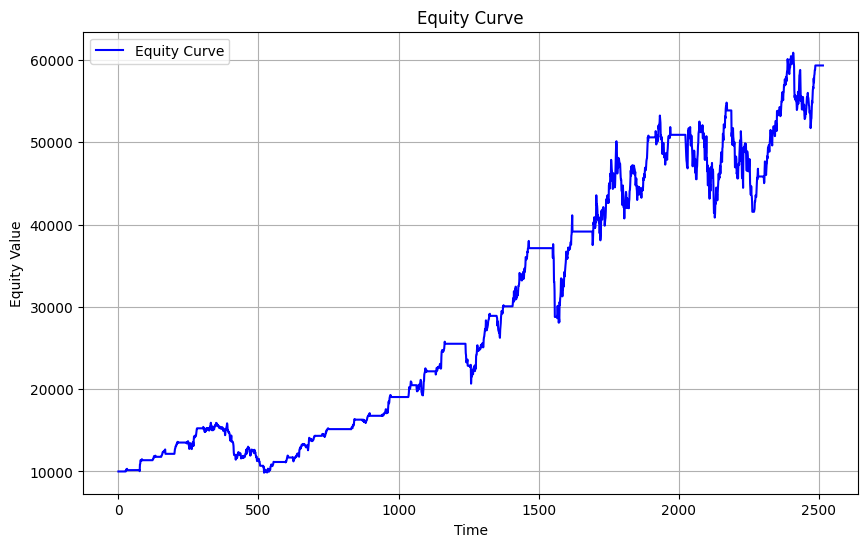

In [ ]:
# Plot equity curve
plot_equity_curve(best_equity_curve)

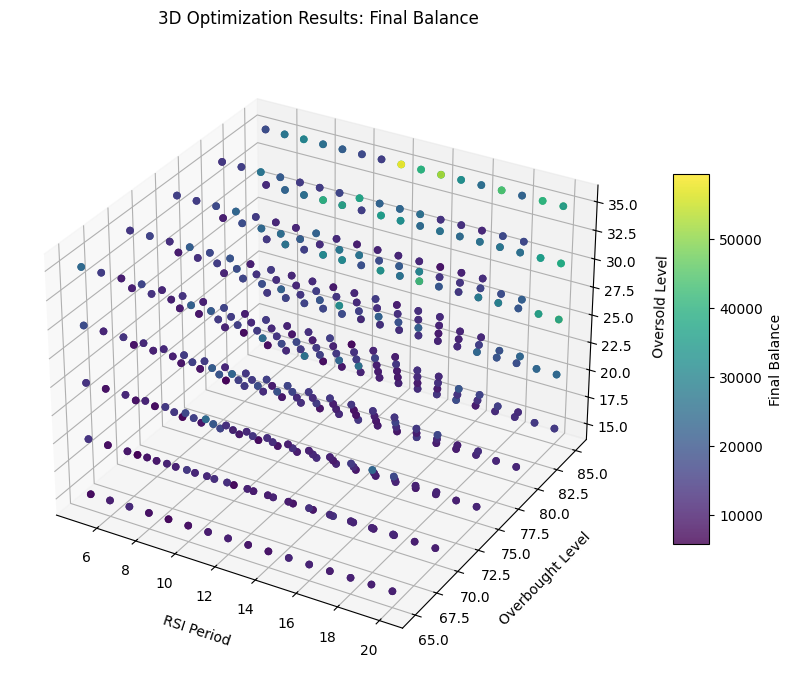

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def plot_3d_optimization_results(results_df):
    """
    Plot the optimization results in 3D.
    """
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Extract data for the plot
    rsi_period = results_df['RSI Period']
    overbought = results_df['Overbought Level']
    oversold = results_df['Oversold Level']
    final_balance = results_df['Final Balance']

    # Create a scatter plot
    scatter = ax.scatter(rsi_period, overbought, oversold, c=final_balance, cmap='viridis', alpha=0.8)

    # Add labels and title
    ax.set_title('3D Optimization Results: Final Balance', pad=20)
    ax.set_xlabel('RSI Period', labelpad=10)
    ax.set_ylabel('Overbought Level', labelpad=10)
    ax.set_zlabel('Oversold Level', labelpad=10)

    # Add color bar for balance
    cbar = fig.colorbar(scatter, ax=ax, shrink=0.6, aspect=10)
    cbar.set_label('Final Balance')

    plt.show()

# Plot the 3D optimization results
plot_3d_optimization_results(results_df)
